# Movie Data Analysis Project 

##### Students: William Bennett, Alex Karadjov

##### Instructor: David Elliot

##### Active Project Dates: May 8th - 12th

<img src='movie-producer-1000x600.jpg' width="600" height="400">


## Business Understanding
#### Business Question
Your company has now seen all the other big companies creating original video content. Your companies board have _decided to create a new movie studio_, but they don’t know anything about _creating movies._ 
<br>
#### Business Proposal
###### We are _charged_ with exploring what types of films are currently doing the _**best at the box office**._

###### We then _translate_ those findings into _undstandable and logistical_ formats 

###### All inorder to give _an insightful _**conclusion**_ on what type of films are the _**best to be creating**._


##### The _best_  at the box office. 
What does **best** mean:
- money
- rating, won’t line pockets
- consistency


_**While keeping these points in mind**_
<br>
<br>
We have decieded these **columns** below will be used directly to _aid us in determining our **business proposal**_**;**
- Gross 
- Avgerage Rating 
- Number of Votes 
- Run Time Minutes
- Region
- Genre

#### Imports

Importing necessary libraries;

In [87]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd # to compare multiple samples
%matplotlib inline



### Understanding the Data
What are we looking at?

#### Connections
Connecting Data to Sqlite;

In [11]:
# Switch these depending on your OS after you unzip the im.db folter
conn = sqlite3.connect('zippedData/im.db') #Mac
# conn = sqlite3.connect('zippedData/im.db/im.db') #PC

Viewing the Data Tables;

In [12]:
schema_df = pd.read_sql("""

SELECT *
FROM sqlite_master

""", conn)

schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [13]:
pd.read_sql("""

SELECT *
FROM movie_basics b
limit 3

""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


In [14]:
pd.read_sql("""

SELECT *
FROM movie_ratings
limit 3

""", conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20


#### Creating DataFrames;

IMDB Movie Data Frame;

In [15]:
df_imdb = pd.read_sql("""

SELECT b.movie_id
       ,b.primary_title
       ,b.original_title
       ,b.start_year
       ,b.runtime_minutes
       ,b.genres
       ,r.averagerating
       ,r.numvotes
       ,a.region
FROM movie_basics b
join movie_ratings r on r.movie_id = b.movie_id
left join movie_akas a on a.movie_id = b.movie_id 

""", conn)

In [16]:
df_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


<br>
Box Office Mojo Movie Data Frame
<br>

In [17]:
df_mg = pd.read_csv('zippedData/bom.movie_gross.csv.gz', sep=',')

In [18]:
df_mg.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Data Preperation
Our main focuses while cleaning will be;

Gross based;
* Remove non US dollar value column
    - Change Null Values to -99999 to create visible outlier

Avgerage Rating based;
* Remove rows from the column avgeragerating if the column numvotes has a row with less than 30 votes
    - drop null values for both columns

Genre based;
* Seperate multiple genre movies
    - drop null values


Run Time Minutes based;
* Handle outliers with long runtimes
    - drop null values


Null Values based;
* Drop and replace based on significance for all significant data used

Column Names based;
* Cleaning the names to the same format


#### Cleaning the Data Frames with Significant Information

<br>
IMBD Data Frame;
<br>
- Clean the column names;

In [19]:
[c.replace("_", "").strip() for c in df_imdb.columns]

['movieid',
 'primarytitle',
 'originaltitle',
 'startyear',
 'runtimeminutes',
 'genres',
 'averagerating',
 'numvotes',
 'region']

In [20]:
df_imdb = df_imdb.rename(columns = dict(zip(df_imdb.columns, [c.replace("_", "").strip() for c in df_imdb.columns])))

In [21]:
df_imdb.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


In [22]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266085 entries, 0 to 266084
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movieid         266085 non-null  object 
 1   primarytitle    266085 non-null  object 
 2   originaltitle   266085 non-null  object 
 3   startyear       266085 non-null  int64  
 4   runtimeminutes  253959 non-null  float64
 5   genres          264736 non-null  object 
 6   averagerating   266085 non-null  float64
 7   numvotes        266085 non-null  int64  
 8   region          218341 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 18.3+ MB


<br>
Box Office Mojo Movie Gross Data Frame
<br>
- Cleaning the column names

In [23]:
df_mg = df_mg.rename(columns = dict(zip(df_mg.columns, [c.replace("_", "").strip() for c in df_mg.columns])))

In [24]:
df_mg[['primarytitle', 'startyear']] = df_mg[['title', 'year']]

In [25]:
df_mg.head()

,title,studio,domesticgross,foreigngross,year,primarytitle,startyear
0,Toy Story 3,BV,415000000.0,652000000,2010,Toy Story 3,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,Alice in Wonderland (2010),2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows Part 1,2010
3,Inception,WB,292600000.0,535700000,2010,Inception,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,Shrek Forever After,2010


In [26]:
df_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          3387 non-null   object 
 1   studio         3382 non-null   object 
 2   domesticgross  3359 non-null   float64
 3   foreigngross   2037 non-null   object 
 4   year           3387 non-null   int64  
 5   primarytitle   3387 non-null   object 
 6   startyear      3387 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 185.4+ KB


#### Creating a Final Data Frame by Combining the Two Data sets 
Final Data Cleaning

In [27]:
df_clean = df_imdb

In [28]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN


In [29]:
# combining the two datasets into a new dataframe
df_clean = pd.merge(df_clean, df_mg, how='left', on=['primarytitle','startyear'])

In [30]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,NaN,NaN
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN



##### Gross Cleaning
Creating a new column for total_gross by combining the domesticgross column and foreigngross column;
<br>

In [31]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,NaN,NaN
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_clean['domesticgross'] = df_clean['domesticgross'].apply(pd.to_numeric, errors = 'coerce').dropna().astype(float)
df_clean['foreigngross'] = df_clean['foreigngross'].apply(pd.to_numeric, errors = 'coerce').dropna().astype(float)

df_clean['total_gross'] = df_clean['domesticgross'] + df_clean['foreigngross']

df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year,total_gross
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,NaN


<br>
Dropping any null values in the total_gross column;

In [33]:
df_clean['total_gross'].isnull().sum()

233310

In [34]:
df_clean['total_gross'].fillna(-999999, inplace=True)

In [35]:
df_clean['total_gross'].isnull().sum()

0

<br>
Checking;

In [36]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,domesticgross,foreigngross,year,total_gross
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,NaN,NaN,-999999.0
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,NaN,NaN,-999999.0


<br>
<br>

Since the **total_gross** column now exists we can drop the **domesticgross** and **foreigngross** columns for a cleaner data set;

In [37]:
df_clean = df_clean.drop('domesticgross', axis = 1)

In [38]:
df_clean = df_clean.drop('foreigngross', axis = 1)

<br>
Checking;

In [39]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,total_gross
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,-999999.0
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0


##### Genre Cleaning
Splitting up the Genres into new columns for multiple genre movies and dropping Null Values;

In [40]:
df_clean['genres'].str.rsplit(",", expand=True)

,0,1,2
0,Action,Crime,Drama
1,Action,Crime,Drama
2,Action,Crime,Drama
3,Action,Crime,Drama
4,Action,Crime,Drama
...,...,...,...
266080,Documentary,None,None
266081,Drama,Family,None
266082,Documentary,None,None
266083,None,None,None


In [41]:
df_clean[['genre_1', 'genre_2', 'genre_3']] = df_clean['genres'].str.rsplit(",", expand=True)

<br>
Checking;

In [42]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,total_gross,genre_1,genre_2,genre_3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama


<br>
Adding filtered data to the new genre columns;
<br>

In [43]:
has_rev_filter = df_clean['total_gross'].notnull()

In [44]:
temp_1 = df_clean[has_rev_filter][['total_gross','genre_1']]
temp_2 = df_clean[has_rev_filter][['total_gross','genre_2']]
temp_3 = df_clean[has_rev_filter][['total_gross','genre_3']]

In [45]:
temp_1.rename(columns={"genre_1": "genre"}, inplace=True)
temp_2.rename(columns={"genre_2": "genre"}, inplace=True)
temp_3.rename(columns={"genre_3": "genre"}, inplace=True)

In [46]:
genre_revenue = temp_1.append(temp_2).append(temp_3).dropna()

<br>
Checking;

In [47]:
genre_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539018 entries, 0 to 266047
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   total_gross  539018 non-null  float64
 1   genre        539018 non-null  object 
dtypes: float64(1), object(1)
memory usage: 12.3+ MB


#### Review Cleaning
<br>
Dropping null values and movies with less than 30 reviews from data frame;

In [48]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,total_gross,genre_1,genre_2,genre_3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama


In [49]:
df_clean['numvotes'].min()

5

In [50]:
df_clean = df_clean[df_clean['numvotes'] >= 30]

<br>
Checking;

In [51]:
df_clean['numvotes'].min()

30

In [52]:
df_clean = df_clean.dropna(subset=['numvotes'])

In [53]:
df_clean['numvotes'].isnull().sum()

0

In [54]:
df_clean.head()

,movieid,primarytitle,originaltitle,startyear,runtimeminutes,genres,averagerating,numvotes,region,title,studio,year,total_gross,genre_1,genre_2,genre_3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,None,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama
4,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,IN,NaN,NaN,NaN,-999999.0,Action,Crime,Drama



##### Runtime Cleaning
<br>
Handling outliers that have significantly longer runtimes than most

In [55]:
df_clean['runtimeminutes'].describe()

count    213027.000000
mean        101.709154
std          37.288181
min           8.000000
25%          90.000000
50%          98.000000
75%         111.000000
max       14400.000000
Name: runtimeminutes, dtype: float64

When checking **outliers** with _.describe()_ 
<br>
<br>
We can observe the **longest** runtimeminutes value is **14400.000000** minutes... thats a very long movie
<br>
<br>
Using a seaborn blox plot we can see the _spread of the **outliers**;_

<br>
Checking;

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='runtimeminutes'>

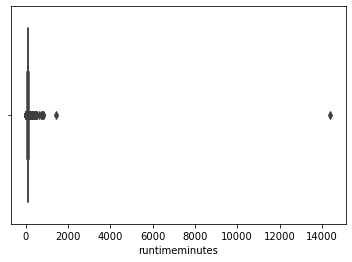

In [56]:
sns.boxplot(df_clean['runtimeminutes'])

<br>
After looking at this boxplot _we can conqure that_ we will **drop** any movies that are **longer than 333.0 minutes** for a cleaner data set
<br>
<br>

In [57]:
df_clean = df_clean[df_clean['runtimeminutes'] <= 333.0]

<br>
Checking;

In [58]:
df_clean['runtimeminutes'].describe()

count    212974.000000
mean        101.549781
std          19.674331
min           8.000000
25%          90.000000
50%          98.000000
75%         111.000000
max         325.000000
Name: runtimeminutes, dtype: float64

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='runtimeminutes'>

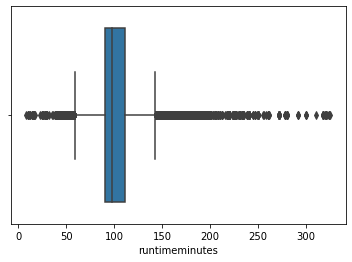

In [59]:
sns.boxplot(df_clean['runtimeminutes'])

We can now actually see something from this box chart, there are still many outliers so we decided to......

# Exploratory Data Analysis
What we found:
- Data freshness, years are from 2010-2019. This is slightly stale.
- Explore the top genres and genre combinations
- Explore runtime
- Explore how ratings is related to gross


In [100]:
# Create a filter for having gross revenue
gross_filter = df_clean['total_gross'].notna()

### Data Freshness

In [63]:
df_imdb['startyear'].describe()

count    266085.000000
mean       2014.163876
std           2.594150
min        2010.000000
25%        2012.000000
50%        2014.000000
75%        2016.000000
max        2019.000000
Name: startyear, dtype: float64

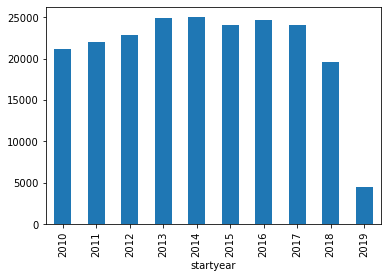

In [70]:
# Check how much data we have for each year
df_clean.groupby('startyear')['movieid'].count().plot.bar();

**Observations**
- This data is from a range of years so we may want to adjust any money values for inflation
- This data does not include the COVID-19 pandemic so any recommendations would need to take that into account

### Genres

In [83]:
# First let's find the top genres
top_genres_combos = list(df_clean.groupby('genres').count().reset_index().nlargest(10, columns='movieid')['genres'])
top_genres_combos

['Drama',
 'Comedy',
 'Documentary',
 'Comedy,Drama',
 'Drama,Romance',
 'Comedy,Drama,Romance',
 'Comedy,Romance',
 'Adventure,Animation,Comedy',
 'Horror',
 'Drama,Thriller']

In [84]:
# Create a filter for only top genres
top_genre_combos_filter = df_clean['genres'].isin(top_genres_combos)

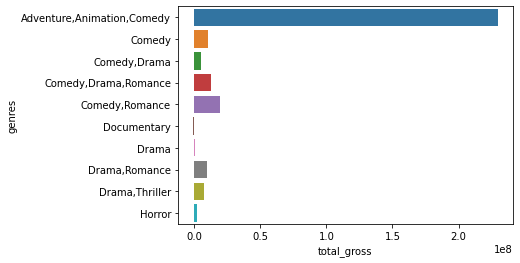

In [86]:
# Compare total gross revenue for top genres
top_genre_combos = df_clean[top_genre_combos_filter].groupby('genres')['total_gross'].mean().reset_index()
sns.barplot(data=top_genre_combos, x='total_gross', y='genres');

**Observations**
- There are similar combinations (Comedy vs. Comedy,Drama) so we may want to split those out
- One category is much higher than the others, it turned out the there were different currencies here so we needed to split out USD only

Are the differences signficiant however, let's find out?

In [89]:
print(pairwise_tukeyhsd(df_clean[top_genre_combos_filter]['total_gross'], df_clean[top_genre_combos_filter]['genres']))

                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
          group1                  group2            meandiff    p-adj       lower           upper      reject
-------------------------------------------------------------------------------------------------------------
Adventure,Animation,Comedy               Comedy -219387959.6425  0.001 -223824027.5136 -214951891.7714   True
Adventure,Animation,Comedy         Comedy,Drama -224831224.1011  0.001 -229389318.5337 -220273129.6685   True
Adventure,Animation,Comedy Comedy,Drama,Romance -216700531.6363  0.001 -221742483.3037 -211658579.9689   True
Adventure,Animation,Comedy       Comedy,Romance -210488477.2121  0.001 -215744917.6769 -205232036.7472   True
Adventure,Animation,Comedy          Documentary -230403344.1556  0.001 -234852701.9218 -225953986.3894   True
Adventure,Animation,Comedy                Drama -229322309.0542  0.001 -233361134.7611 -225283483.3472   True
Adventure,

**Observations**
- [TBD]

### Runtime
What we found:
- There were a significant number of outliers
- There were movies with 5k runtime minutes, which is way too long for a movie
- We will want to categorize these to see if there is an optimal length

In [93]:
# Explore the column
df_clean['runtimeminutes'].describe()

count    212974.000000
mean        101.549781
std          19.674331
min           8.000000
25%          90.000000
50%          98.000000
75%         111.000000
max         325.000000
Name: runtimeminutes, dtype: float64

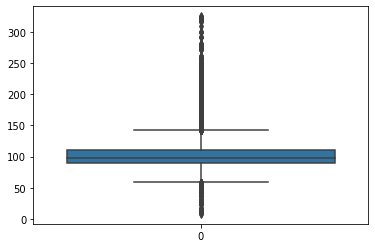

In [92]:
# Let's explore the runtime data
sns.boxplot(data=df_clean['runtimeminutes']);

# Modeling
What we will be doing:
- Categorize movies by genre (split out the genre string)
- Categorize movies based on runtime

### Genre

### Runtime

We need to start feature engineering for runtime. Instead of trying to optimize runtime for gross revenue we will instead categorize runtime and compare revenue among the newly created categories

In [96]:
# Create a function to categorize runtimes
def film_categorization(runtime):
    """
    Input: the movie runtime (float)
    Output: the movie runtime category (string)
    """
    movie_category = ''
    if runtime < 40: # The movie industry considers this a short film
        movie_category =  'Short Film'
    elif runtime < 96: # This is outside the common hollywood length
        movie_category =  'Normal Film (short)'
    elif (runtime >= 96) and (runtime <= 120): # 50% of hollywood movies are in this range
        movie_category =  'Normal Film (optimal)'
    elif (runtime > 120): # These are longer than the common range
        movie_category =  'Normal Film (long)'
    else: # if no runtime exists
        movie_category =  'No Runtime'
    return movie_category

In [97]:
# Add a new column categorizing the runtime
df_clean['runtimecategory'] = df_clean['runtimeminutes'].apply(film_categorization)
df_clean['runtimecategory'].value_counts()

Normal Film (short)      92477
Normal Film (optimal)    90456
Normal Film (long)       29983
Short Film                  58
Name: runtimecategory, dtype: int64

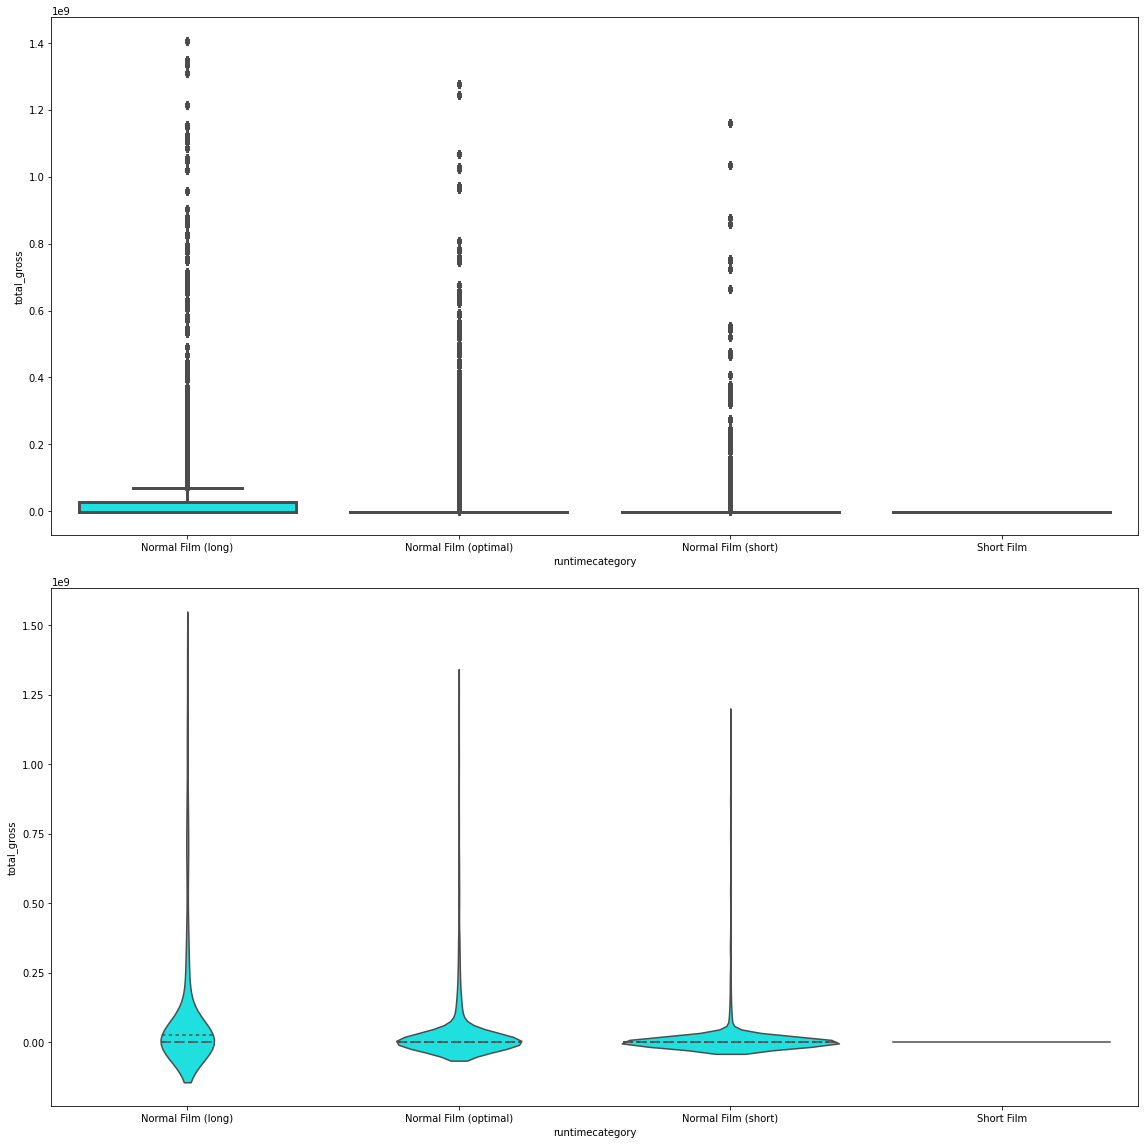

In [98]:
# Visualize the distributions
fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16, 16))

sns.boxplot(
    x="runtimecategory",
    y="total_gross",
    data=df_clean,
    ax=ax0,
    color='aqua', 
    linewidth=3
)



sns.violinplot(
    x="runtimecategory",
    y="total_gross",
    data=df_clean,
    ax=ax1,
    color='aqua',
    inner="quartile",  # Seeing the mean and quartiles
    bw=.3              # How much smoothing do we use
)

plt.tight_layout();

In [101]:
# Check for significant differences between the four categories
print(pairwise_tukeyhsd(df_clean[gross_filter]['total_gross'], df_clean[gross_filter]['runtimecategory']))

                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
        group1                group2           meandiff    p-adj       lower          upper      reject
-------------------------------------------------------------------------------------------------------
   Normal Film (long) Normal Film (optimal) -64999309.5723  0.001  -67107337.8623 -62891281.2823   True
   Normal Film (long)   Normal Film (short) -85575229.9422  0.001  -87677516.0249 -83472943.8596   True
   Normal Film (long)            Short Film -96455275.8416  0.001 -138032429.0518 -54878122.6315   True
Normal Film (optimal)   Normal Film (short) -20575920.3699  0.001  -22055231.6498   -19096609.09   True
Normal Film (optimal)            Short Film -31455966.2693 0.2094  -73006278.2315  10094345.6928  False
  Normal Film (short)            Short Film -10880045.8994    0.9  -52430066.9301  30669975.1313  False
----------------------------------------------------------------

**Observations**
- [TBD]